In [2]:
from collections import namedtuple

In [3]:
import torch

import cv2

import os

import pandas as pd

import matplotlib.pyplot as plt

import json

from PIL import Image

from matplotlib.patches import Polygon

In [4]:
from torchvision.transforms import Compose
import torch.nn as nn

# Create File Path Dataframes



- Contains the paths to images instead of images themselves

In [5]:


#--------------------------------------------------------------------------------

# Definitions

#--------------------------------------------------------------------------------



# a label and all meta information

Label = namedtuple( 'Label' , [



    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .

                    # We use them to uniquely name a class



    'id'          , # An integer ID that is associated with this label.

                    # The IDs are used to represent the label in ground truth images

                    # An ID of -1 means that this label does not have an ID and thus

                    # is ignored when creating ground truth images (e.g. license plate).



    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth

                    # images for training.

                    # For training, multiple labels might have the same ID. Then, these labels

                    # are mapped to the same class in the ground truth images. For the inverse

                    # mapping, we use the label that is defined first in the list below.

                    # For example, mapping all void-type classes to the same ID in training,

                    # might make sense for some approaches.



    'category'    , # The name of the category that this label belongs to



    'categoryId'  , # The ID of this category. Used to create ground truth images

                    # on category level.



    'hasInstances', # Whether this label distinguishes between single instances or not



    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored

                    # during evaluations or not



    'color'       , # The color of this label

    ] )





#--------------------------------------------------------------------------------

# A list of all labels

#--------------------------------------------------------------------------------



# Please adapt the train IDs as appropriate for you approach.

# Note that you might want to ignore labels with ID 255 during training.

# Make sure to provide your results using the original IDs and not the training IDs.

# Note that many IDs are ignored in evaluation and thus you never need to predict these!



labels = [

    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color

    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),

    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),

    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),

    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),

    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),

    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),

    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),

    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),

    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),

    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),

    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),

    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),

    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),

    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),

    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),

    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),

    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),

    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),

    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),

    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),

    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),

    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),

    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),

    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),

    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),

    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),

    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),

    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),

]

In [6]:
# Function to generate file paths for train dataset

def get_train_file_paths(images_dir, labels_dir):

    data = []

    # Iterate through cities in the train images folder

    for city in os.listdir(images_dir):

        city_image_dir = os.path.join(images_dir, city)

        city_label_dir = os.path.join(labels_dir, city)

        if os.path.isdir(city_image_dir) and os.path.isdir(city_label_dir):

            for file in os.listdir(city_image_dir):

                if file.endswith('_leftImg8bit.png'):

                    image_path = os.path.join(city_image_dir, file)

                    image_name = file.replace('_leftImg8bit.png', '')

                    image_label_path = os.path.join(city_label_dir, f'{image_name}_gtFine_labelTrainIds.png')

                    image_polygons_path = os.path.join(city_label_dir, f'{image_name}_gtFine_polygons.json')

                    data.append([image_path, image_label_path, image_polygons_path])

    return pd.DataFrame(data, columns=['image_path', 'image_label_path', 'image_polygons_path'])



# Function to generate file paths for test dataset

def get_test_file_paths(test_dir):

    data = []

    # Iterate through cities in the test images folder

    for city in os.listdir(test_dir):

        city_dir = os.path.join(test_dir, city)

        if os.path.isdir(city_dir):

            for file in os.listdir(city_dir):

                if file.endswith('_leftImg8bit.png'):

                    image_path = os.path.join(city_dir, file)

                    data.append([image_path])

    return pd.DataFrame(data, columns=['image_path'])



# Paths to images and labels directories

images_dir_train = '/kaggle/input/cityscapes-segmentation/images/train'

labels_dir_train = '/kaggle/input/cityscapes-segmentation/labels/train'

images_dir_test = '/kaggle/input/cityscapes-segmentation/images/test'



# Create train and test DataFrames

train_df = get_train_file_paths(images_dir_train, labels_dir_train)

test_df = get_test_file_paths(images_dir_test)

## Example for the paths

In [8]:
print(train_df['image_path'][100])

print(train_df['image_label_path'][100])

print(train_df['image_polygons_path'][100])

/kaggle/input/cityscapes-segmentation/images/train/dusseldorf/dusseldorf_000214_000019_leftImg8bit.png
/kaggle/input/cityscapes-segmentation/labels/train/dusseldorf/dusseldorf_000214_000019_gtFine_labelTrainIds.png
/kaggle/input/cityscapes-segmentation/labels/train/dusseldorf/dusseldorf_000214_000019_gtFine_polygons.json


# Visualization

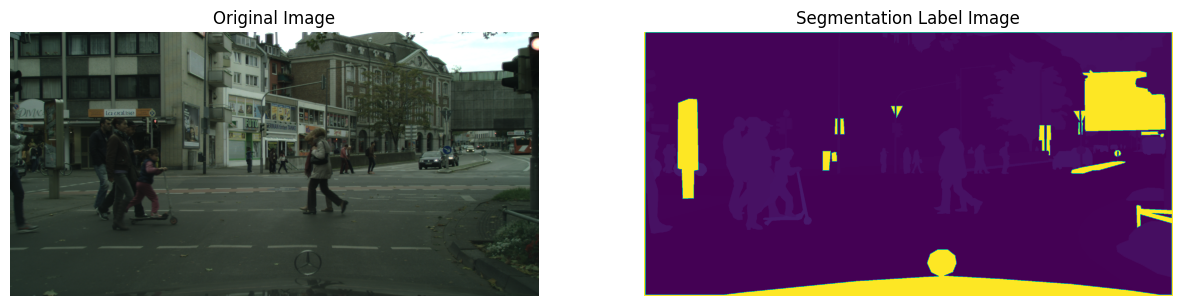

In [9]:
def visualize_train_row(row):

    # Load the image

    image = Image.open(row['image_path'])

    

    # Load the label image (segmentation map)

    label_image = Image.open(row['image_label_path'])



    # Visualize the image and label side by side

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))



    # Display the original image

    ax[0].imshow(image)

    ax[0].set_title('Original Image')

    ax[0].axis('off')



    # Display the label (segmentation) image

    ax[1].imshow(label_image)

    ax[1].set_title('Segmentation Label Image')

    ax[1].axis('off')



    plt.show()





# Example usage with a row from train_df

visualize_train_row(train_df.iloc[1000])


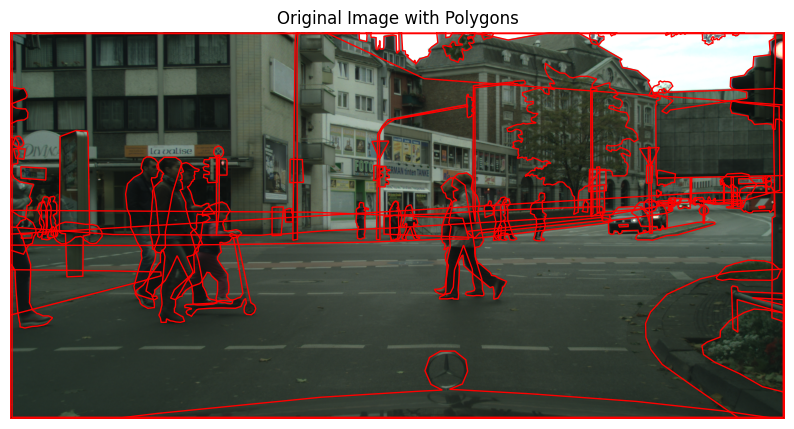

In [10]:
def visualize_train_row_with_polygons(row):

    # Load the original image

    image = Image.open(row['image_path'])



    # Load and parse the polygons JSON

    with open(row['image_polygons_path'], 'r') as f:

        polygons_data = json.load(f)

    

    # Visualize the image

    fig, ax = plt.subplots(figsize=(10, 10))

    

    # Display the original image

    ax.imshow(image)

    # Iterate through the objects in the JSON file

    for obj in polygons_data['objects']:

        polygon_coords = obj['polygon']

        

        # Create a Polygon patch with the coordinates from JSON

        polygon = Polygon(polygon_coords, closed=True, edgecolor='red', fill=False, linewidth=1)

        

        # Add the polygon patch to the image plot

        ax.add_patch(polygon)

    

    # Set title and show the image with polygons overlaid

    ax.set_title('Original Image with Polygons')

    ax.axis('off')

    

    plt.show()



    #Print the JSON polygons data for reference

    # print("Polygons data from JSON file:")

    # print(json.dumps(polygons_data, indent=4))



# Example usage with a row from train_df

visualize_train_row_with_polygons(train_df.iloc[1000])


# Val/Train Split + Saving to CSV

In [11]:
#TODO : Split the dataset into training and validation data

print("Number of Samples before Split: ", len(train_df))



# Shuffle the DataFrame

train_df = train_df.sample(frac=1).reset_index(drop=True)



# Calculate the number of samples for

val_size = 380



# Split the DataFrame into train and validation sets

train_df_final = train_df[:-val_size].reset_index(drop=True)

val_df_final = train_df[-val_size:].reset_index(drop=True)



print("Train Samples (After Split): ", len(train_df_final))

print("Val Samples (After Split): ", len(val_df_final))



#TODO : Save the split to csv file

train_df_final.to_csv("train_data.csv", index=False)

val_df_final.to_csv("val_data.csv", index=False)

test_df.to_csv("test_data.csv", index=False)

Number of Samples before Split:  2380
Train Samples (After Split):  2000
Val Samples (After Split):  380


In [ ]:
#PRINT SAMPLE FROM CSV_FILE

# Data Analysis



### Write Most Important Notes Here:



- Image dimensions are (1024, 2048, 3)

- Mask is of shape (1024, 2048)

- Datatypes for both are uint8

In [ ]:
#TODO: write your own data analysis techniques

# Preprocessing

In [13]:
# Example for the desired interface 



class LoadImage():

   def __init__(self, keys):

       self.keys=keys

   def __call__(self,sample):

       for key in self.keys:

           sample[key]= sample[key]

       return sample

In [15]:
#TODO : TRAIN DATA PREPROCESSING PIPELINE

Train_data_transform=Compose([

    LoadImage(['image','mask']),

    # Write your own data transforms and augmentations



])





#TODO : VALIDATION DATA PREPROCESSING PIPELINE





Valid_data_transform=Compose([

    LoadImage(['image','mask']),

    # Write your own data transforms and augmentations



])



#TODO : TEST DATA PREPROCESSING PIPELINE





Test_data_transform=Compose([

    LoadImage(['image']), # No mask since it is a test image

    # Write your own data transforms and augmentations



])

In [16]:
import re

from torch.utils.data import DataLoader, Dataset

import pandas as pd

from typing import List

from torchvision.transforms import Compose



class Dataset(Dataset):

    def __init__(self, input_dataframe: pd.DataFrame, data_transform:Compose, has_labels=True):

        self.input_dataframe = input_dataframe

        self.data_transform = data_transform

        self.has_labels = has_labels



    def __getitem__(self, item: int):

        sample_idx = item

        sample = {}

        sample['image'] = torch.from_numpy(cv2.imread(self.input_dataframe['image_path'][sample_idx], cv2.IMREAD_UNCHANGED))/255

        if self.has_labels:

           sample['mask'] = torch.from_numpy(cv2.imread(self.input_dataframe['image_label_path'][sample_idx], cv2.IMREAD_UNCHANGED))

        sample = self.data_transform(sample)
        
        # Bring channel dimension first
        sample['image'] = torch.permute(sample['image'], (2, 0, 1))
        sample['mask'] = sample['mask'].to(torch.int64)

        return sample

        

        

    def __len__(self):

        return len(self.input_dataframe)

In [17]:
#TODO : Initilize your datasets



ds_train=Dataset(input_dataframe=train_df_final,

                data_transform=Train_data_transform)

ds_val = Dataset(input_dataframe=val_df_final,

                data_transform=Valid_data_transform)


In [18]:
#TODO : Show samples from your data loaders

def print_batch_info(data_loader):

  """Prints information about batches from a DataLoader.



  Args:

    data_loader: The DataLoader to inspect.

  """



  for batch in data_loader:

    print("Batch Images shape:", batch['image'].shape)

    print("Batch Masks shape:", batch['mask'].shape)

    print("Batch Images dtype:", batch['image'].dtype)

    print("Batch Masks dtype:", batch['mask'].dtype)

    print("Batch Image device:", batch['image'].device)

    print("Batch Masks device:", batch['mask'].device)

    print("\n")

    break # print for first batch only



# Example usage

dl_train = DataLoader(dataset=ds_train, batch_size=4, num_workers=4, prefetch_factor=8, shuffle=True)
dl_val=DataLoader(dataset=ds_val,batch_size= 8 ,num_workers=4 ,prefetch_factor=8,shuffle=True)


print_batch_info(dl_train)

Batch Images shape: torch.Size([4, 3, 1024, 2048])
Batch Masks shape: torch.Size([4, 1024, 2048])
Batch Images dtype: torch.float32
Batch Masks dtype: torch.int64
Batch Image device: cpu
Batch Masks device: cpu




# Model (U-NET)

In [19]:
#TODO : Write the model you are going to use (Pytorch)


class UNet(nn.Module):
    def double_convolution(self, in_channels, out_channels):
        conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv_op
    
    def __init__(self, num_classes=20):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        
        # Each convolution is applied twice.
        self.down_convolution_1 = self.double_convolution(3, 16)
        self.down_convolution_2 = self.double_convolution(16, 32)
        self.down_convolution_3 = self.double_convolution(32, 64)
        self.down_convolution_4 = self.double_convolution(64, 128)
        self.down_convolution_5 = self.double_convolution(128, 256)
        
        
        
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2, 
            stride=2)
        self.up_convolution_1 = self.double_convolution(256, 128)
        
        
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2, 
            stride=2)
        self.up_convolution_2 = self.double_convolution(128, 64)
        
        
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=64, out_channels=32,
            kernel_size=2, 
            stride=2)
        self.up_convolution_3 = self.double_convolution(64, 32)
        
        
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=32, out_channels=16,
            kernel_size=2, 
            stride=2)
        self.up_convolution_4 = self.double_convolution(32, 16)
        

        self.out = nn.Conv2d(
            in_channels=16, out_channels=num_classes, 
            kernel_size=1
        )
        

        
    def forward(self, x):
        # Input x shape is [batch_size, 3, 1024, 2048]
        
        # Contracting
        down_1 = self.down_convolution_1(x) 
        down_2 = self.max_pool2d(down_1) 
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4) 
        down_6 = self.max_pool2d(down_5) 
        down_7 = self.down_convolution_4(down_6) 
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8) # [batch_size, 256, 64, 128]
        
        
        # Expanding
        up_1 = self.up_transpose_1(down_9) # [batch_size, 128, 128, 256]
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x) 
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1)) # [batch_size, 16, 1024, 2048]
        
        out = self.out(x) # [batch_size, num_classes, 1024, 2048]
        return out



    
    
# # Test for the model
# model = UNet()
# output = None
# inp = None
# label = None
# for batch in dl_train:
#     inp = batch['image']
#     label = batch['mask']
#     output = model(batch['image'])
#     break



# Loss

In [25]:
#TODO : Write the loss function you are going to use
import torch.optim as optim

model = UNet()
loss = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Test for the loss
# print(output.shape)
# print(inp.shape)
# print(label.shape)
# print(output.dtype)
# print(inp.dtype)
# print(label.dtype)


# print(loss(output,label))

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
import torch
from tqdm import tqdm




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/kaggle/input/unet_v1/pytorch/default/1/model_UNET.pth', map_location=device, weights_only=True))


losses = []
val_acc = []
avg_dices = []
def train_unet_model(model, dataloader, criterion, optimizer, num_epochs=10, device=device):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Progress bar for the epoch
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))

        for i, batch in pbar:
            inputs = batch['image'].to(device)
            masks = batch['mask'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()
            pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / (i+1):.4f}")
        losses.append(running_loss) # For Graph

        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(dataloader):.4f}")
        
        
        
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            total_dice = 0
            for idx, batch in enumerate(dl_val):
                inp = batch['image'].to(device)
                label = batch['mask'].to(device)
        
                mask = (label != 255)
                label = label[mask]
                
                output = model(inp)
                prediction = torch.argmax(output, dim=1).squeeze(1)
                prediction = prediction[mask]  # Apply the mask to predictions
                
                correct += (prediction == label).sum().item()
                total += label.numel()
                total_dice += dice_score_multiclass(prediction, label, num_classes=20)

            validation_accuracy = correct / total
            avg_dice = (total_dice / len(dl_val)).item()
            val_acc.append(validation_accuracy)
            avg_dices.append(avg_dice)
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {validation_accuracy}, Dice: {avg_dice}")

    print("Training complete")


In [31]:
train_unet_model(model, dl_train, loss, optimizer)  # training on 10 epochs

model_path = 'model_UNET.pth'
torch.save(model.state_dict(), model_path)

Epoch [1/10], Loss: 0.5861: 100%|██████████| 500/500 [05:39<00:00,  1.47it/s]

Epoch [1/10], Average Loss: 0.5861


Epoch [1/10], Validation Accuracy: 0.8165410204341076, Dice: 0.4137868285179138


Epoch [2/10], Loss: 0.5840: 100%|██████████| 500/500 [05:37<00:00,  1.48it/s]

Epoch [2/10], Average Loss: 0.5840


Epoch [2/10], Validation Accuracy: 0.8463349161825402, Dice: 0.4421517848968506


Epoch [3/10], Loss: 0.5470: 100%|██████████| 500/500 [05:37<00:00,  1.48it/s]

Epoch [3/10], Average Loss: 0.5470


Epoch [3/10], Validation Accuracy: 0.8494203402555435, Dice: 0.4623682498931885


Epoch [4/10], Loss: 0.5096: 100%|██████████| 500/500 [05:37<00:00,  1.48it/s]

Epoch [4/10], Average Loss: 0.5096


Epoch [4/10], Validation Accuracy: 0.8557957217513419, Dice: 0.44366198778152466


Epoch [5/10], Loss: 0.4884: 100%|██████████| 500/500 [05:37<00:00,  1.48it/s]

Epoch [5/10], Average Loss: 0.4884


Epoch [5/10], Validation Accuracy: 0.8608270305661194, Dice: 0.46654292941093445


Epoch [6/10], Loss: 0.4677: 100%|██████████| 500/500 [05:37<00:00,  1.48it/s]

Epoch [6/10], Average Loss: 0.4677


Epoch [6/10], Validation Accuracy: 0.8644389130482942, Dice: 0.47673118114471436


Epoch [7/10], Loss: 0.4543: 100%|██████████| 500/500 [05:36<00:00,  1.48it/s]

Epoch [7/10], Average Loss: 0.4543


Epoch [7/10], Validation Accuracy: 0.8689932226409173, Dice: 0.4671887755393982


Epoch [8/10], Loss: 0.4511: 100%|██████████| 500/500 [05:36<00:00,  1.49it/s]

Epoch [8/10], Average Loss: 0.4511


Epoch [8/10], Validation Accuracy: 0.8702816333372321, Dice: 0.4999510645866394


Epoch [9/10], Loss: 0.4324: 100%|██████████| 500/500 [05:36<00:00,  1.48it/s]

Epoch [9/10], Average Loss: 0.4324


Epoch [9/10], Validation Accuracy: 0.8767541211854217, Dice: 0.49089527130126953


Epoch [10/10], Loss: 0.4191: 100%|██████████| 500/500 [05:36<00:00,  1.49it/s]

Epoch [10/10], Average Loss: 0.4191


Epoch [10/10], Validation Accuracy: 0.8650437090359921, Dice: 0.5007543563842773
Training complete


# Eval Metrics

In [32]:

def dice_score_multiclass(pred, target, num_classes):
    smooth = 1e-6  # to avoid division by zero
    total_dice = 0

    # Calculate dice score for each class (0 to num_classes-1)
    for cls in range(num_classes):
        # Create binary masks for the current class
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()

        # Calculate intersection and union
        intersection = (pred_cls * target_cls).sum()
        dice = (2. * intersection + smooth) / (pred_cls.sum() + target_cls.sum() + smooth)

        total_dice += dice

    # Average over all classes
    avg_dice = total_dice / num_classes
    return avg_dice


# Validation Accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    total_dice = 0
    for idx, batch in enumerate(dl_val):
        inp = batch['image'].to(device)
        label = batch['mask'].to(device)

        mask = (label != 255)
        label = label[mask]
        
        output = model(inp)
        prediction = torch.argmax(output, dim=1).squeeze(1)
        prediction = prediction[mask]  # Apply the mask to predictions
        
        correct += (prediction == label).sum().item()
        total += label.numel()
        total_dice += dice_score_multiclass(prediction, label, num_classes=20)
    
    validation_accuracy = correct / total
    avg_dice = (total_dice / len(dl_val)).item()
    print("Validation Accuracy:", validation_accuracy)
    print("Average Dice Score:", avg_dice)




Validation Accuracy: 0.8650437090359921
Average Dice Score: 0.5000781416893005


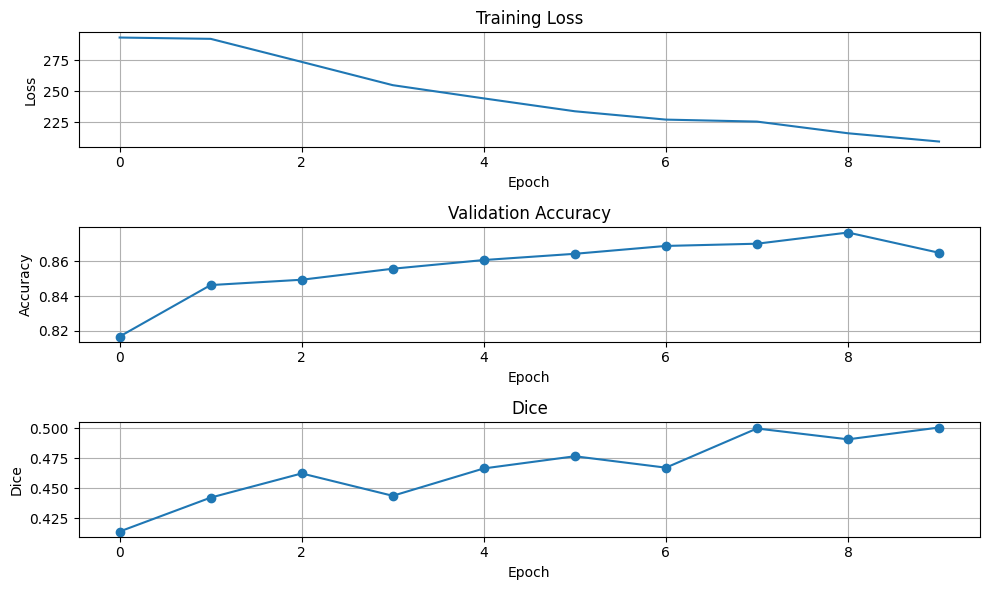

In [34]:
#TODO : Plot losses and metrics graphs
# Plot Losses and Validation Accuracy
plt.figure(figsize=(10, 6))

# Plot Losses

plt.subplot(3, 1, 1)
plt.plot(range(len(losses)), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(range(len(val_acc)), val_acc, marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)


plt.subplot(3, 1, 3)
plt.plot(range(len(avg_dices)), avg_dices, marker='o')
plt.title('Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_30/2399481955.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')  # Choose a colormap (adjust as needed)


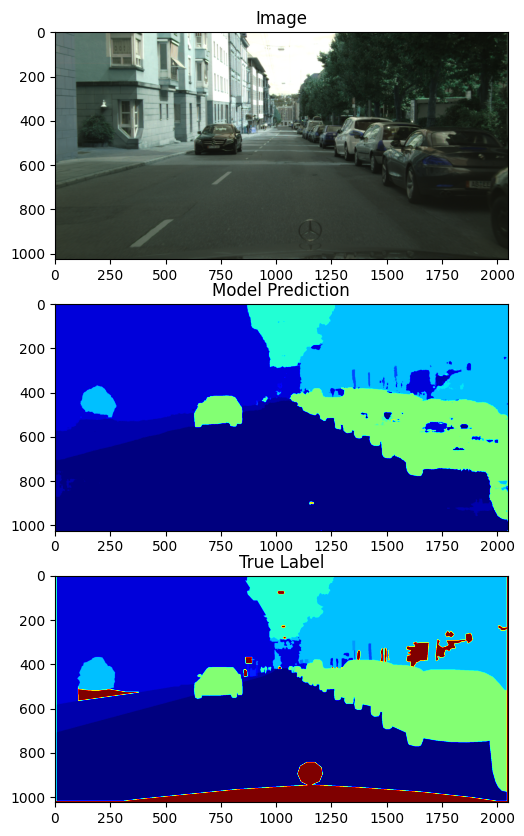

In [37]:
import numpy as np 

sample = ds_train.__getitem__(124)

inp = sample['image'].unsqueeze(0).to(device) # Add dimension of 1 to beginning torch.Size([1, 3, 1024, 2048])

prediction = model(inp).argmax(dim=1).squeeze(1).squeeze(0) # Remove first two dimesnions of 1 to betorch.Size([1024, 2048])

# Assuming you have your image and label tensors defined as 'image' and 'label'


# Assuming you have your image and label tensors defined as 'image' and 'label'

# Convert image to PIL Image for display (assuming channels are first)
image_pil = np.transpose(sample['image'].numpy(), (1, 2, 0))*255
image_pil = Image.fromarray(image_pil.astype(np.uint8))

# Scale the label values to 0-190 (if needed)
label_scaled = (prediction.to('cpu') * 10).long()  # Convert to long for integer values

mask_scaled = torch.clamp(sample['mask'] * 10, 0, 255).long()




# Combine mask and label values (assuming they have the same range)
combined_values = np.stack((label_scaled, mask_scaled), axis=-1)  # Stack along channel dimension
combined_values_flat = combined_values.flatten()  # Flatten for color mapping

# Create a colormap for both label and mask
cmap = plt.cm.get_cmap('jet')  # Choose a colormap (adjust as needed)

# Create a color lookup table (LUT) from the colormap
norm = plt.Normalize(min(combined_values_flat), max(combined_values_flat))





# Display the image and label
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(image_pil)
plt.title('Image')

plt.subplot(3, 1, 2)
plt.imshow(label_scaled,  cmap=cmap, norm=norm)
plt.title('Model Prediction')


plt.subplot(3, 1, 3)
plt.imshow(mask_scaled,  cmap=cmap, norm=norm)
plt.title('True Label')

plt.show()